In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.datasets import fetch_20newsgroups
import stop_words
import gensim
import nltk
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
EXCLUDE_SYMBOLS_STR = ''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є',
                               '‹', '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—',
                               '‘', '\x7f', '\xad', '¤', '\xa0'])

In [4]:
regex_puncts = re.compile('[%s]' % re.escape(string.punctuation))
regex_symbs = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_digits = re.compile('[%s]' % re.escape(string.digits))
regex_spaces = re.compile('[%s]' % string.printable + string.whitespace)
regex_emoji = re.compile("["
                         "\U0001F600-\U0001F64F"  # emoticons
                         "\U0001F300-\U0001F5FF"  # symbols & pictographs
                         "\U0001F680-\U0001F6FF"  # transport & map symbols
                         "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                         "]+")
morph = pymorphy2.MorphAnalyzer()



In [5]:
import time
import xml.etree.cElementTree as ET

In [6]:
import stop_words

In [7]:
tree = ET.ElementTree(file="file1.xml")
root = tree.getroot()
data_full= []

catalog=root[0][0]
for i in range(50):
    data_full.append(catalog[i].text)
catalog=root[0][1]
for i in range(50,100):
    data_full.append(catalog[i-50].text)
catalog=root[0][2]
for i in range(100,150):
    data_full.append(catalog[i-100].text)
catalog=root[0][3]
for i in range(150,200):
    data_full.append(catalog[i-150].text)

---

In [8]:
data_train = data_full

print(len(data_train))

200


### Preprocessing

In [9]:
texts_prep = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', txt) for txt in data_train]

In [10]:
texts_prep = [regex_emoji.sub(' ', txt) for txt in texts_prep]

In [11]:
texts_prep = [regex_puncts.sub(' ', txt) for txt in texts_prep]

In [12]:
texts_prep = [regex_symbs.sub('', txt) for txt in texts_prep]

In [13]:
texts_prep = [regex_digits.sub(' ', txt) for txt in texts_prep]

In [14]:
texts_prep = [regex_spaces.sub(' ', txt) for txt in texts_prep]

In [15]:
texts_prep = [txt.strip().replace('\t', ' ').replace('\n', ' ').lower() for txt in texts_prep]

In [16]:
texts_prep = [re.sub( '\s+', ' ', txt).strip() for txt in texts_prep]

In [17]:
texts_prep[:20]

['легенда смешанных единоборств mma федор емельяненко мог в очередной раз в карьере стать чемпионом однако финал гран при тяжеловесов bellator пошел совсем не по сценарию россиянина как американцу райану бэйдеру удалось превзойти последнего императора о главном бое bellator расскажет лента ру на закате империи пускай последний император с видимой легкостью разобрался с двумя соперниками по гран при его все равно считали андердогом в противостоянии с бэйдером впечатляющие победы над двумя американскими ветеранами бывшими бойцами абсолютного бойцовского чемпионата ufc фрэнком миром и чейлом сонненом оставили больше вопросов чем ответов в какой форме емельяненко насколько уверенно он себя чувствует в вязкой борьбе на канвасе с миром федор разобрался слишком быстро чтобы делать хоть какие либо выводы да и кто знает что ждало россиянина если бы ему не удалось перебить соперника в стойке соннен человек по сути из другой весовой категории для него удары емельяненко были как поцелуи с восточны

In [18]:
stops=stop_words.get_stop_words('ru')
wnl = nltk.WordNetLemmatizer()
stemmer = PorterStemmer()

In [19]:
corpus = []

for sentence in log_progress(texts_prep[::]):
    tokens = sentence.split(' ')
#     tokens = [t for t in tokens if t not in stops]
    tokens = [wnl.lemmatize(t) for t in tokens if t not in stops]
#     tokens = [stemmer.stem(t) for t in tokens if t not in stops]
    tokens = [t for t in tokens if len(t) >= 3]
    corpus.append(tokens)

## LSA

**LSA = TFIDF + SVD**

In [20]:
vectorizer = TfidfVectorizer()

In [21]:
X = vectorizer.fit_transform([' '.join(tokens) for tokens in corpus])

print(X.shape)

(200, 24382)


In [22]:
vectorizer.vocabulary_

{'легенда': 8993,
 'смешанных': 19538,
 'единоборств': 5633,
 'mma': 416,
 'федор': 22792,
 'емельяненко': 5686,
 'очередной': 13338,
 'карьере': 7767,
 'стать': 20543,
 'чемпионом': 23568,
 'финал': 22904,
 'гран': 4402,
 'тяжеловесов': 21881,
 'bellator': 79,
 'пошел': 15631,
 'сценарию': 20935,
 'россиянина': 18440,
 'американцу': 1065,
 'райану': 17649,
 'бэйдеру': 2303,
 'удалось': 22056,
 'превзойти': 15759,
 'последнего': 15359,
 'императора': 7132,
 'главном': 4080,
 'бое': 1934,
 'расскажет': 17783,
 'лента': 9050,
 'закате': 6179,
 'империи': 7139,
 'пускай': 17197,
 'последний': 15363,
 'император': 7131,
 'видимой': 2721,
 'легкостью': 9012,
 'разобрался': 17577,
 'двумя': 4685,
 'соперниками': 19959,
 'равно': 17361,
 'считали': 20971,
 'андердогом': 1120,
 'противостоянии': 16986,
 'бэйдером': 2302,
 'впечатляющие': 3259,
 'победы': 14147,
 'американскими': 1054,
 'ветеранами': 2602,
 'бывшими': 2280,
 'бойцами': 1955,
 'абсолютного': 765,
 'бойцовского': 1958,
 'чемпиона

In [23]:
keys = list(vectorizer.vocabulary_.keys())
values = list(vectorizer.vocabulary_.values())

_ind = np.argsort(values)
words_sorted = np.asarray(keys)[_ind]

print(len(keys), len(values), len(words_sorted))

24382 24382 24382


In [34]:
N_TOPICS = 15
svd = TruncatedSVD(n_components=N_TOPICS, n_iter=10).fit(X)

['боя' 'поединок' 'весе' 'американец' 'гран' 'бой' 'января' 'бэйдер'
 'bellator' 'емельяненко']
[0.09709879 0.09830936 0.10015327 0.13203743 0.13415385 0.14873694
 0.16753679 0.16963624 0.17073327 0.49149626]

['россии' 'картина' 'января' 'стены' 'скрылся' 'посетителей' 'глазах'
 'третьяковской' 'галереи' 'куинджи']
[0.08417596 0.08447748 0.08524331 0.08602733 0.09199092 0.11024422
 0.11353581 0.12353003 0.13968373 0.17243217]

['стены' 'музея' 'архипа' 'картину' 'скрылся' 'посетителей' 'глазах'
 'третьяковской' 'галереи' 'куинджи']
[0.13020581 0.13419116 0.13869806 0.13926602 0.15004915 0.17318399
 0.18639431 0.20462894 0.23149283 0.28797578]

['турнира' 'место' 'чемпионат' 'заняла' 'фигуристка' 'самодурова' 'россии'
 'чемпионате' 'европы' 'загитова']
[0.08046407 0.09124751 0.091803   0.09534682 0.10430971 0.10696422
 0.10948465 0.17327293 0.20994424 0.21622573]

['самолет' 'катании' 'фигуристка' 'место' 'авиакомпании' 'заняла'
 'самодурова' 'чемпионате' 'европы' 'загитова']
[0.079305

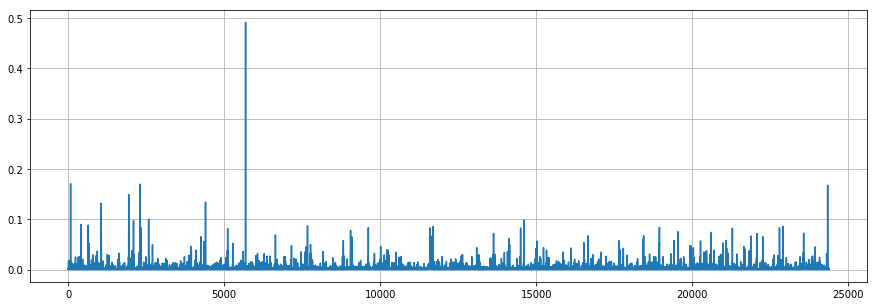

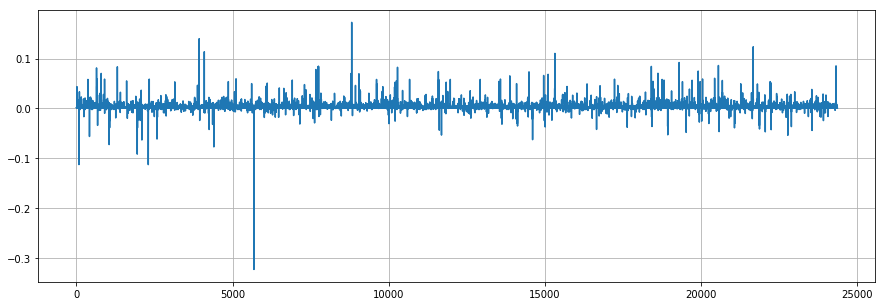

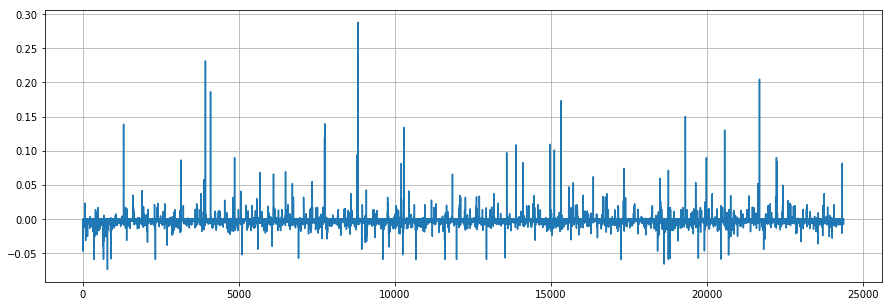

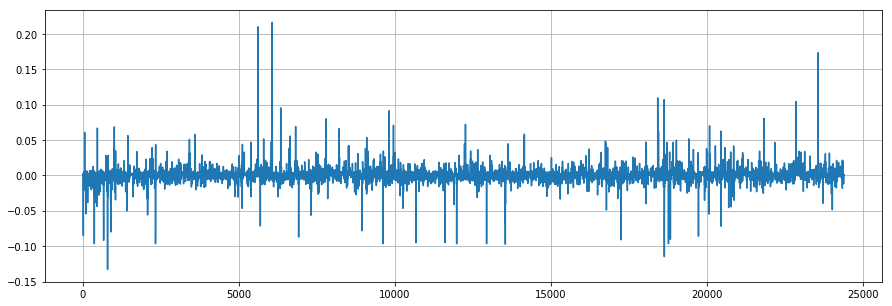

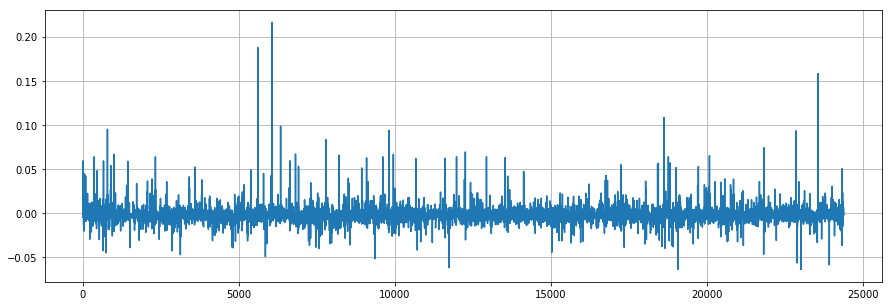

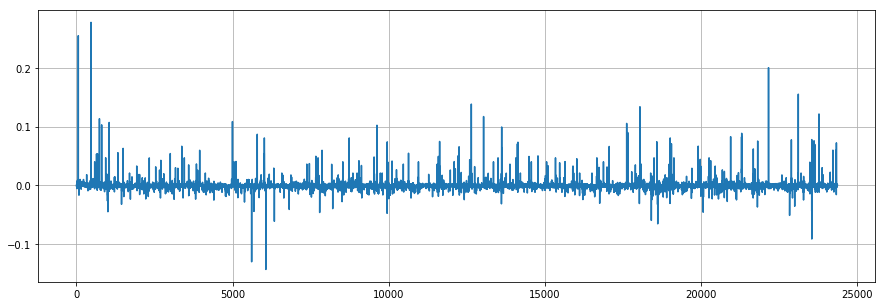

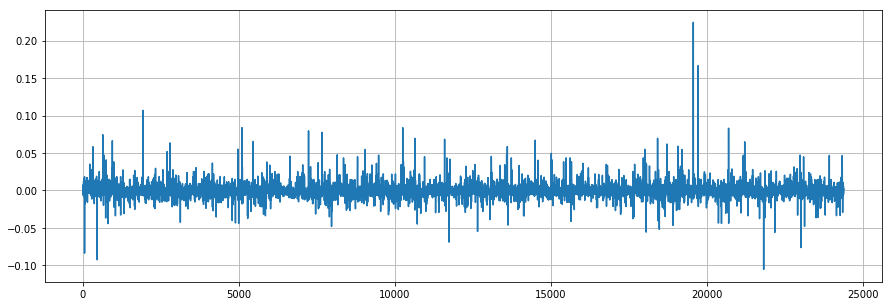

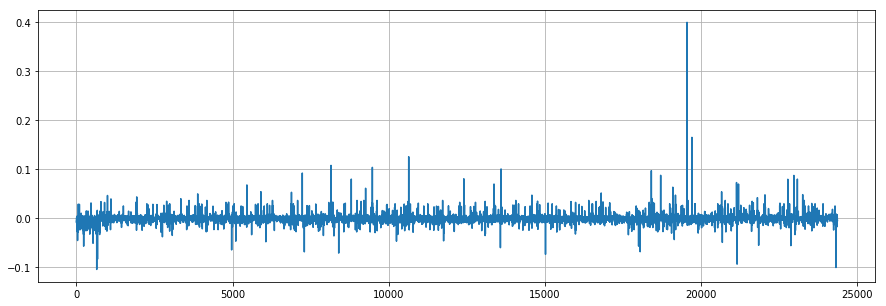

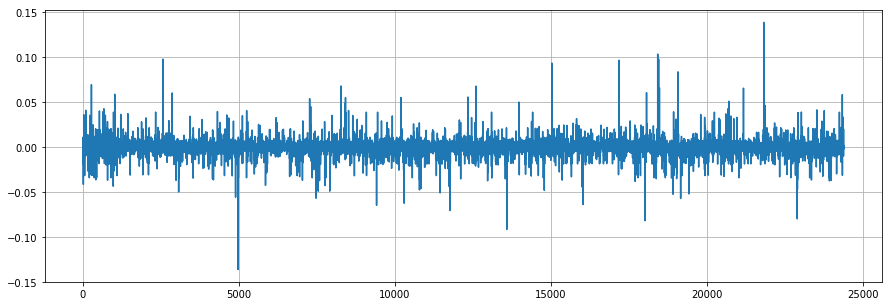

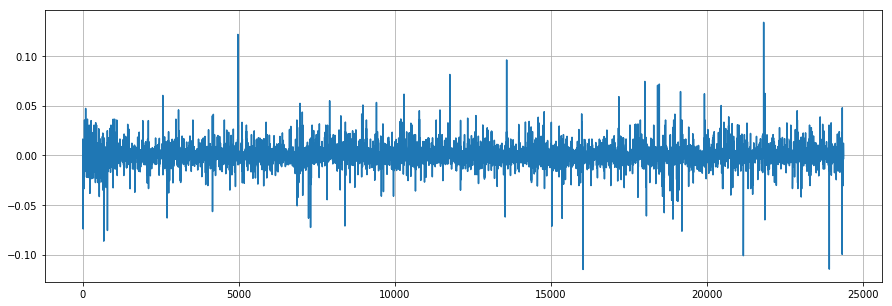

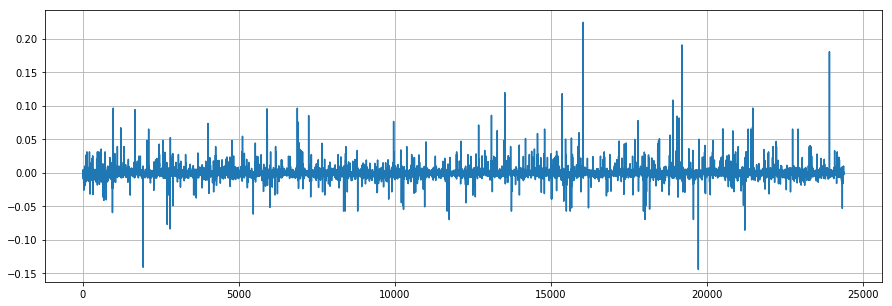

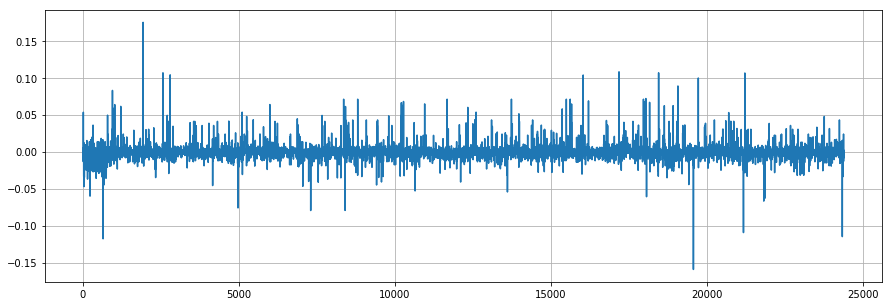

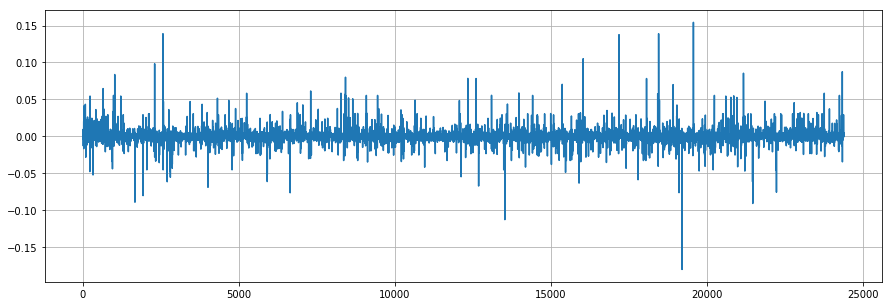

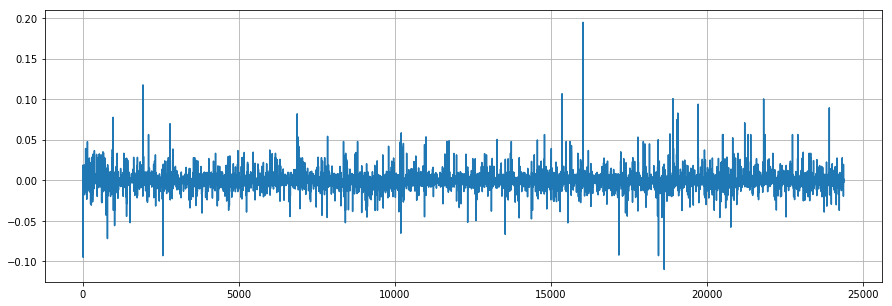

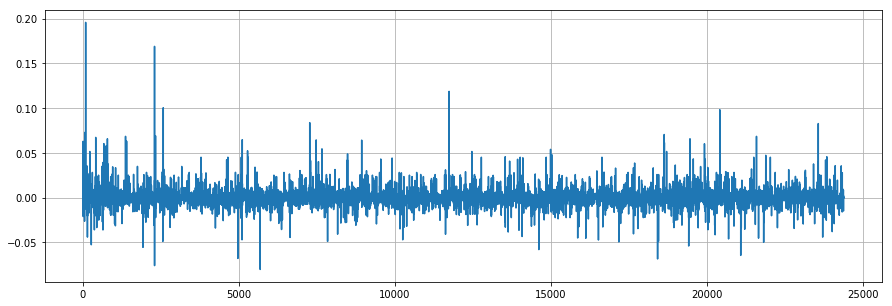

In [35]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(svd.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
    
    tmp = stub.copy()
    tmp[i] = 1
    plt.figure(figsize=(15, 5))
    plt.plot(svd.components_[i])
    plt.grid(True)
#     break

### [LSA gensim](https://radimrehurek.com/gensim/models/lsimodel.html)

## LDA

**LDA = LSA + Dirichlet**

### gensim

**[sklearn-like API](https://radimrehurek.com/gensim/sklearn_api/ldaseqmodel.html)**

In [36]:
dictionary = corpora.Dictionary(corpus)

In [37]:
X_bow = [dictionary.doc2bow(text) for text in corpus]

In [38]:
lda_gensim = gensim.models.ldamodel.LdaModel(X_bow, num_topics=N_TOPICS, id2word=dictionary, iterations=10)

In [39]:
lda_gensim.print_topics()

[(0,
  '0.003*"лента" + 0.002*"новостей" + 0.002*"января" + 0.002*"канале" + 0.002*"telegram" + 0.002*"подписывайтесь" + 0.002*"важных" + 0.001*"материалы" + 0.001*"теме" + 0.001*"россии"'),
 (1,
  '0.002*"новостей" + 0.002*"telegram" + 0.002*"подписывайтесь" + 0.002*"лента" + 0.002*"канале" + 0.002*"января" + 0.002*"дня" + 0.002*"россии" + 0.001*"важных" + 0.001*"фото"'),
 (2,
  '0.002*"новостей" + 0.002*"подписывайтесь" + 0.002*"канале" + 0.002*"января" + 0.002*"telegram" + 0.002*"лента" + 0.002*"дня" + 0.001*"россии" + 0.001*"материалы" + 0.001*"фото"'),
 (3,
  '0.002*"канале" + 0.002*"новостей" + 0.002*"лента" + 0.002*"января" + 0.002*"telegram" + 0.001*"теме" + 0.001*"подписывайтесь" + 0.001*"россии" + 0.001*"материалы" + 0.001*"важных"'),
 (4,
  '0.003*"канале" + 0.003*"telegram" + 0.002*"лента" + 0.002*"подписывайтесь" + 0.002*"важных" + 0.002*"новостей" + 0.002*"января" + 0.001*"дня" + 0.001*"россии" + 0.001*"материалы"'),
 (5,
  '0.003*"января" + 0.003*"telegram" + 0.003*"подп

**[multi-core version](https://radimrehurek.com/gensim/models/ldamulticore.html)**

### sklearn

In [43]:
lda_sklearn = LatentDirichletAllocation(n_components=N_TOPICS, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X)

iteration: 1 of max_iter: 10, perplexity: 66587562.9022
iteration: 2 of max_iter: 10, perplexity: 57877334.5103
iteration: 3 of max_iter: 10, perplexity: 53262801.0082
iteration: 4 of max_iter: 10, perplexity: 50060771.5139
iteration: 5 of max_iter: 10, perplexity: 46712992.1885
iteration: 6 of max_iter: 10, perplexity: 42966151.5466
iteration: 7 of max_iter: 10, perplexity: 39312980.7539
iteration: 8 of max_iter: 10, perplexity: 36697615.1663
iteration: 9 of max_iter: 10, perplexity: 35075578.7265
iteration: 10 of max_iter: 10, perplexity: 34277020.0659


In [32]:
lda_sklearn.components_.shape

(15, 24382)

In [33]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(lda_sklearn.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
#     break

['плишковой' 'продолжался' 'партиях' 'выбила' 'номер' 'пырьева' 'актриса'
 'пырьев' 'васильева' 'студент']
[0.09709879 0.09830936 0.10015328 0.13203744 0.13415386 0.14873694
 0.16753678 0.16963626 0.17073328 0.49149626]

['орел' 'ryanair' 'ирландской' 'ростех' 'вертолеты' 'куршевель' 'бейдер'
 'кино' 'facebook' 'whatsapp']
[0.0841758  0.08447742 0.08524328 0.08602736 0.09199098 0.11024422
 0.11353582 0.12353005 0.13968375 0.17243219]

['henn' 'федор' 'актриса' 'скабеева' 'сидоренко' 'кейт' 'amazon'
 'пенальти' 'бекинсейл' 'осака']
[0.13020529 0.1341911  0.13869812 0.1392659  0.15004889 0.17318315
 0.18639432 0.20462899 0.23149323 0.28797594]

['картину' 'стены' 'музея' 'скрылся' 'посетителей' 'глазах'
 'третьяковской' 'фото' 'галереи' 'куинджи']
[0.08045837 0.09124525 0.09181244 0.09534083 0.10431544 0.10695834
 0.10947584 0.17327742 0.20994088 0.21621542]

['сибирь' 'xlayre' 'команда' 'google' 'comedy' 'club' 'университета'
 'батрутдинов' 'чикатило' 'клуба']
[0.07929728 0.08332621 0.0

### [Dynamic topic modeling (gensim)](https://radimrehurek.com/gensim/models/ldaseqmodel.html)